# ASR-QA
## Lucida AI Evaluation

### Experiment Setup

1. `Kaldi Text-to-Speech` is turned into a [`Docker image`](https://hub.docker.com/r/ybga/kaldi_tts/tags/)
2. `Client` is my local machine (including a `cpp` tester and a `python` wrapper around the tester)
3. `Kaldi ASR` has three kinds of DNN models: `fisher`, `librispeech`, and `tedlium`, all running on our server under `Kubernetes`
4. `QA` comes in two flavors: `OpenEphyra` running on the our server under `Kubernetes`, and `GoogleQA` which is essentially `google.com`

### Infrastructure Architecture
![alt text](diagram.png "Infrastructure Architecture")

In [1]:
# Code to generate the above flowchart
# using http://knsv.github.io/mermaid/live_editor/.
# %% Example diagram
# graph LR
#     0((Kaldi TTS)) -- Audio --> 1[Client]
#     1[Client] -- Audio -->2((Fisher))
#     1[Client] -- Audio --> 3((Librispeech))
#     1[Client] -- Audio --> 4((Tedlium))
#     2 -- Text --> 5{Client}
#     3 -- Text --> 5(Client)
#     4 -- Text --> 5(Client)
#     5 -- Text --> 6((OpenEphyra))
#     5 -- Text --> 7((GoogleQA))
#     6 -- Text --> 8[Client]
#     7 -- Text --> 8[Client]
#     style 0 fill:#AED6F1,stroke:#333;
#     style 1 fill:#FCF3CF,stroke:#333;
#     style 5 fill:#FCF3CF,stroke:#333;
#     style 6 fill:#E8DAEF,stroke:#333;
#     style 7 fill:#E8DAEF,stroke:#333;
#     style 8 fill:#FCF3CF,stroke:#333;

### Steps of Data Processing

1. Preprocess raw data
from `txt` files to `pandas DataFrame`s
2. Analyze
from `pandas DataFrame`s to statistics (python objects)
3. Plot
from statistics to `matplotlib` plots

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import re, string
from operator import itemgetter
import matplotlib.pyplot as plt

# Returns a DataFrame from the file with the following format:
# <audio_path>,<transcript>
# in which the audio path is of the following format:
# "path/to/file/<query_id>_<text>.wav"
# An example file:
# ../asr_qa/speech/0_Helloworld.wav,"hello world."
# The DataFrame has only one column: transcript
# with the specified header
# and sorted by the query id.
def get_df_from_asr_result(file_path, header):
    file = open(file_path, 'r')
    lines = file.readlines()
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        # The first occurrence of a number is assumed to be the query id.
        id = int(re.search(r'\d+', line).group())
        transcript = line.split(',')[1]
        if transcript.startswith('"') and transcript.endswith('"'):
            transcript = transcript[1:-1]
        proc_lines.append((id, transcript))
    proc_lines.sort(key=itemgetter(0)) # sort data by ID
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

data = pd.read_csv('text/query.txt')

asr_labels = ['fisher', 'librispeech', 'tedlium']

for asr_label in asr_labels:
    data = data.join \
    (get_df_from_asr_result('asr_result_{}.txt'.format(asr_label), \
                            'transcript_{}'.format(asr_label)))

In [3]:
# Add double quotes to each filed of a csv file 
# whcih has two fields.
# Print the processed lines out.
def add_double_quotes(file_path):
    file = open(file_path, 'r')
    lines = file.readlines()
    file.close()
    def process_str(str):
        return '"' + str + '"' if str and str[0] != '"' else str
    for line in lines:
        line = line.lstrip().rstrip('\n')
        first = line.split(',')[0]
        second = line.split(',')[1:]
        second = ''.join(x for x in second)
        print(process_str(first) + ',' + process_str(second))
        
# Normalize the following files.
files_to_normaliz = []
for file_path in files_to_normaliz:
    add_double_quotes(file_path)

In [4]:
# Remove pucntuations from the string.
def stripped_str(str):
    return str.translate(str.maketrans('', '', string.punctuation))

# Returns a DataFrame from the file with the following format:
# <query>,<answer>
# An example file:
# "who is the president of usa.","Factoid not found in knowledge base."
# The DataFrame has only one column: answer
# with the specified header
# and sorted by the row index row `row_index` which satisfies
# data[match_col][row_index] == query.
def get_df_from_qa_result(file_path, header, data, match_col):
    file = open(file_path, 'r')
    lines = file.readlines()
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        query = line.split(',')[0]
        match_row = -1
        for j, match_transcript in enumerate(data[match_col]):
            if stripped_str(match_transcript) == stripped_str(query):
                if match_row != -1:
                    raise RuntimeError('Find the query ' + query +' again!')
                match_row = j
        if match_row == -1:
            raise RuntimeError('Cannot find the query ' + query)
        # Have found exactly one line that matches the transcript.
        answer = line.split(',')[1:]
        answer = ''.join(x for x in answer)
        answer = answer.replace('Factoid not found in knowledge base.', '')
        answer = answer.replace(' (from Wikipedia: ', '')
        answer = answer.replace(')', '')
        if answer.startswith('"') and answer.endswith('"'):
            answer = answer[1:-1]
        if answer == '':
            answer = 'null'
        proc_lines.append((match_row, answer))
    assert(len(proc_lines) == len(lines))
    proc_lines.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

qa_labels = [('fisher_oe', 'transcript_fisher'), \
             ('fisher_google', 'transcript_fisher'), \
             ('librispeech_oe', 'transcript_librispeech'), \
             ('librispeech_google', 'transcript_librispeech'), \
             ('tedlium_oe', 'transcript_tedlium'), \
             ('tedlium_google', 'transcript_tedlium'), \
             ('regular_oe', 'query'), \
             ('regular_google', 'query')]

for qa_label, match_col in qa_labels:
    data = data.join \
    (get_df_from_qa_result('qa_result_{}.txt'.format(qa_label), \
                           'answer_{}'.format(qa_label), data, \
                           match_col), lsuffix='')


### Processed Data as a Table
Let's print it out!

In [5]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1) # display full text
data = data[['query', 'answer', 'answer_regular_oe', 'answer_regular_google',  \
             'transcript_fisher', 'answer_fisher_oe', 'answer_fisher_google', \
             'transcript_librispeech', 'answer_librispeech_oe', 'answer_librispeech_google', \
             'transcript_tedlium', 'answer_tedlium_oe', 'answer_tedlium_google']]
data.to_csv('data.txt') # save to disk

In [6]:
display(data[0:1])

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
0,Who is the current president of the United States of America?,Barack Obama,Barack Obama,Barack Obama,so is the current president of the united states of america.,null,Barack Obama,WHO IS THE CURRENT PRESIDENT OF THE UNITED STATES OF AMERICA.,Barack Obama,Barack Obama,who is the current president of the united states of america.,Barack Obama,Barack Obama


### Data Observations

- Interrogative pronouns are pivotal

    When, what, who, etc.

In [7]:
display(data[14:15]) # "who" vs "so"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
14,Who is the president of France?,François Hollande,de Gaulle,François Hollande,so is the president of france.,null,François Hollande,WHO IS THE PRESIDENT OF FRANCE.,de Gaulle,François Hollande,who is the president of france.,de Gaulle,François Hollande


In [8]:
display(data[62:63]) # "where" vs "well"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
62,Where was Jack Ma born?,Hangzhou China,China,Hangzhou,well i just it's not learn.,null,null,WHERE WAS JACK MA BORN.,The Art Institute of Boston,Hangzhou,where was jack from a born.,Earth,null


- Named entities are important

    Name, location, event, etc. 

In [9]:
display(data[63:64]) # "Hillary Clinton"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
63,Where was Hillary Clinton born?,"Edgewater Hospital, Chicago (Illinois)",New York,Chicago,hello salary clinton born.,null,null,WHERE WAS HILARY CLINTON BORN.,Sydney,Chicago,why was harry plant and born.,null,null


In [10]:
display(data[68:69]) # "Facebook"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
68,Where are the Headquarters of Facebook located?,Menlo Park CA (California),Roanoke,Menlo Park,hi i'm had florida's a cloak aided.,null,null,WHERE ARE THE HEADQUARTERS OF FOSSBROOKE LOCATED.,Downtown Detroit,null,where and the headquarters of fuss the cloak a good.,Earth,null


In [11]:
display(data[58:59]) # "Minecraft"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
58,When was Minecraft released to the public?,17 May 2009,September 30 2012,17 May 2009,well i mean crossed released to the public.,null,null,ONE WAS IN CROFT RELEASED TO THE PUBLIC.,null,null,when was named prof released to the public.,null,null


- Verbs are important

In [12]:
display(data[29:30]) # "right" vs "wrote"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
29,Who wrote the Declaration of Independence?,Thomas Jefferson Benjamin Franklin Roger Sherman John Adams and Robert R. Livingston,Jefferson,Thomas Jefferson,right the declaration of independence.,null,null,WHO WROTE THE DECLARATION OF INDEPENDENCE.,null,Thomas Jefferson,here at the declaration of independence.,null,null


- Other types of keywords are also important

In [13]:
(data[85:86]) # asking "length", NOT "shuttle and for"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
85,What is the total length of the Golden Gate Bridge?,"8981′, 8,981 ft, 8,981 feet",80000 miles,8981′,what is the travel length of the golden gate bridge.,null,8981 ft,WHAT IS THAT OF A LENGTH OF THE GOLDEN GATE BRIDGE.,Eric Steel,8981 feet,what is the shuttle and for the golden gate bridge.,San Francisco side,null


- With the above types of errors being said, `OpenEphyra` is bad itself (even when transcript is perfect)

In [14]:
display(data[59:60]) # ending date, NOT starting date

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
59,When was the Standard Oil company formed?,1870,November 13 1911,1870,unless the standard oil company formed.,BP,null,WHEN WAS THE STANDARD OIL COMPANY FORMED.,May 15 1911,1870,when was the standard oil company formed.,November 13 1911,1870


- Error tolearance: `OpenEphyra` can beat `GoogleQA`

    Sometimes `OpenEphyra` is less restrictive on certain keywords;
    
    Its bag-of-words approach can tolerate keywords errors

In [15]:
display(data[48:49]) # "sign" or "flight" does not matter

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
48,When was the first flight of the Wright brothers?,"17-Dec-03, Thursday December 17 1903",Thursday December 17 1903,17-Dec-03,when was the first sign of the wright brothers.,December 17 1903,null,WHEN WAS THE FIRST FLIGHT OF THE RIGHT BROTHERS.,December 6 1907,17-Dec-03,when was the first flight of the wright brothers.,Thursday December 17 1903,17-Dec-03


In [16]:
display(data[61:62]) # "varied" or "buried" does not matter

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
61,Where is Abraham Lincoln buried?,Oak Ridge Cemetery Springfield IL (Illinois),Illinois,Oak Ridge Cemetery,where is abraham lincoln varied.,Illinois,null,WHERE IS ABRAHAM LINCOLN VARIED.,Indiana,null,where is abraham lincoln varied.,Illinois,null


- Error tolearance: sometimes `GoogleQA` can also ignore such errors

In [17]:
display(data[28:29]) # "he wrote", "had" vs "who wrote"

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
28,Who wrote A Brief History of Time?,Stephen Hawking,Stephen Hawking,Stephen Hawking,really brief history of time.,null,null,HE WROTE A BRIEF HISTORY OF TIME.,null,Stephen Hawking,had a brief history of time.,null,Stephen Hawking


- No ASR model always wins

    Sometimes `fisher` can beat `librispeech`:

In [18]:
display(data[56:57])

,query,answer,answer_regular_oe,answer_regular_google,transcript_fisher,answer_fisher_oe,answer_fisher_google,transcript_librispeech,answer_librispeech_oe,answer_librispeech_google,transcript_tedlium,answer_tedlium_oe,answer_tedlium_google
56,When was the first Disneyland opened?,17-Jul-55,September 16 2008,17-Jul-55,when was the first disneyland opened.,September 30 2011,17-Jul-55,ONE WAS THE FIRST DOES THE LAND OPENED.,null,null,when was the first disneyland opened.,September 30 2011,17-Jul-55


### Observation Summary

- Error of keywords: interrogative pronouns, named entities, verbs, etc.

- General performance: `OpenEphyra` is worse than `GoogleQA`

- Error tolerance: both can sometimes tolerate

- ASR trade-off

In [19]:
# Returns the error rate of str2 given str1 as the correct text.
def error_rate(str1, str2):
    split1 = stripped_str(str1).lower().split()
    split2 = stripped_str(str2).lower().split()
    correct_count = 0
    wront_count = 0
    for word in split1:
        if word in split2:
            correct_count += 1
        else:
            wront_count += 1
    return wront_count / (correct_count + wront_count)

# Returns true if the answer is the same as the correct answer.
# Returns false otherwise.
def answer_is_correct(answer, correct_answer):
    return answer.lower() in correct_answer.lower()

# Analyzes the data for the specified ASR and returns the statistics.
def analyze(data, asr_name, qa_name, verbose=True):
    size = data.shape[0]
    asr_errors = np.zeros(size)
    for j, transcript in enumerate(data['_'.join(['transcript', asr_name])]):
        asr_errors[j] = error_rate(data['query'][j], transcript)
    scores = np.zeros(size)
    relative_scores = np.zeros(size)
    regular_qa_result = np.zeros(size)
    qa_result = np.zeros(size)
    for j, answer in enumerate(data['_'.join(['answer', asr_name, qa_name])]):
        correct_answer = data['answer'][j]
        regular_answer = data['_'.join(['answer', 'regular', qa_name])][j]
        if answer_is_correct(regular_answer, correct_answer):
            # Regualr is correct.
            regular_qa_result[j] = 1
            if not answer_is_correct(answer, correct_answer):
                # Become wrong.
                scores[j] = 0
                relative_scores[j] = -2
            else:
                # Still correct.
                if verbose:
                    print('@@@ 1', correct_answer, ';', answer)
                scores[j] = 1
                relative_scores[j] = 1
                qa_result[j] = 1
        else:
            # Regular is wrong.
            if not answer_is_correct(answer, correct_answer):
                # Still wrong.
                scores[j] = 0
                relative_scores[j] = -1
            else:
                # Become correct!
                if verbose:
                    print('@@@ 2', correct_answer, ';', answer)
                scores[j] = 1
                relative_scores[j] = 2
                qa_result[j] = 1
    
    avg_qa_accuracy = np.count_nonzero(qa_result) / qa_result.size
    avg_regular_qa_accuracy = np.count_nonzero(regular_qa_result) / regular_qa_result.size
    print('avg_asr_error:', asr_errors.mean(), \
          'avg_qa_accuracy:', avg_qa_accuracy, \
          'avg_regular_qa_accuracy', avg_regular_qa_accuracy)
    return {'asr_name': asr_name, 'qa_name': qa_name, \
            'asr_errors': asr_errors, \
            'avg_asr_error': asr_errors.mean(), \
            'relative_scores': relative_scores, \
            'regular_qa_result': regular_qa_result, 'qa_result': qa_result, \
            'avg_qa_accuracy': avg_qa_accuracy, \
            'avg_regular_qa_accuracy': avg_regular_qa_accuracy}

# Sets up plotting scheme.
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

# Plots the relative scores vs error rates for a particular ASR+QA combination.
def plot_score_vs_error(color, asr_name, qa_name, asr_errors, relative_scores, **extras):
    plt.xlabel('Error Rate')
    plt.ylabel('Score')
    plt.title(' '.join([asr_name, qa_name]))
    plt.scatter(asr_errors, relative_scores, label=asr_name, color=color)


### Plot OpenEphyra Performance

1. Baseline is OpenEphyra with the original text query

2. `Score` is relative to the baseline:

    - If the baseline is correct but the ASR causes it to be wrong, the score is -2
    - If the baseline is correct and the ASR does not change the result, the score is +1
    - If the baseline is wrong and the ASR does not change the result, the score is -1
    - If the baseline is wrong but the ASR causes it to be correct, the score is +2

@@@ 1 17-Dec-03, Thursday December 17 1903 ; December 17 1903
@@@ 1 Oak Ridge Cemetery Springfield IL (Illinois) ; Illinois
@@@ 1 Egypt ; Egypt
@@@ 1 Valladolid Spain ; Spain
avg_asr_error: 0.429871406371 avg_qa_accuracy: 0.04 avg_regular_qa_accuracy 0.33


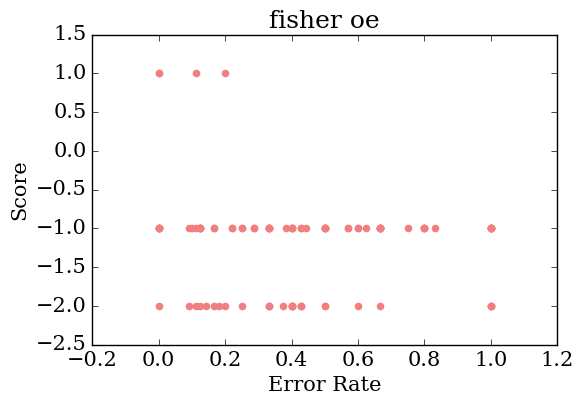

In [20]:
openephyra_stats_list = []
openephyra_stats_list.append(analyze(data, 'fisher', 'oe'))
plot_score_vs_error('lightcoral', **openephyra_stats_list[-1])

@@@ 1 Barack Obama ; Barack Obama
@@@ 1 Xi Jinping, Hu Jintao ; Hu Jintao
@@@ 1 Alexander Graham Bell and Antonio Meucci ; Alexander Graham Bell
@@@ 1 Roald Amundsen ; Amundsen
@@@ 1 Geoffrey Chaucer ; Chaucer
@@@ 1 Henry Puyi ; Puyi
avg_asr_error: 0.265864080364 avg_qa_accuracy: 0.06 avg_regular_qa_accuracy 0.33


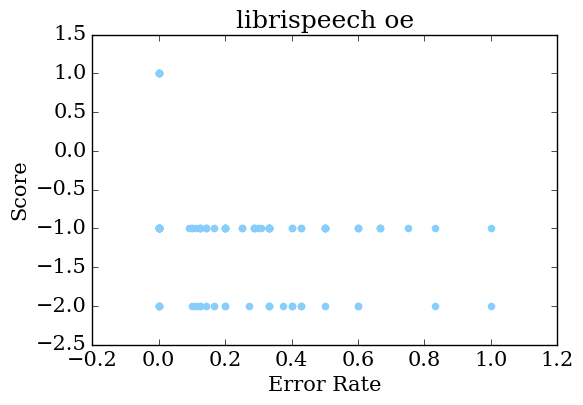

In [21]:
openephyra_stats_list.append(analyze(data, 'librispeech', 'oe'))
plot_score_vs_error('lightskyblue', **openephyra_stats_list[-1])

@@@ 1 Barack Obama ; Barack Obama
@@@ 1 Xi Jinping, Hu Jintao ; Hu Jintao
@@@ 1 Bill Gates ; Gates
@@@ 1 Sep-38, September 30 1938 ; September 30 1938
@@@ 1 17-Dec-03, Thursday December 17 1903 ; Thursday December 17 1903
@@@ 1 Oak Ridge Cemetery Springfield IL (Illinois) ; Illinois
@@@ 1 Valladolid Spain ; Spain
@@@ 1 Mona Lisa ; Mona Lisa
avg_asr_error: 0.310111083361 avg_qa_accuracy: 0.08 avg_regular_qa_accuracy 0.33


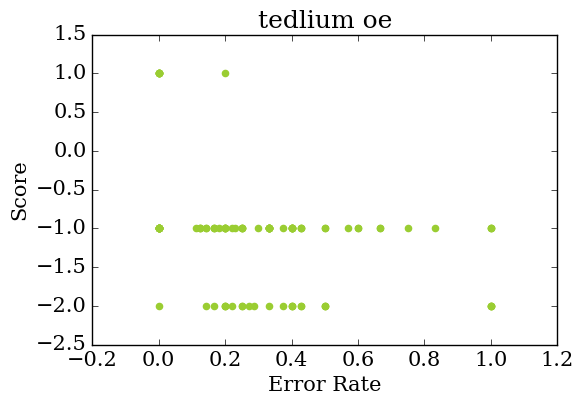

In [22]:
openephyra_stats_list.append(analyze(data, 'tedlium', 'oe'))
plot_score_vs_error('yellowgreen', **openephyra_stats_list[-1])

In [23]:
# Returns the data from the list of QA statistics (one for each ASR model).
def gather_data_for_qa_vs_asr(stats_list):
    asr_name_list = [stats['asr_name'] for stats in stats_list]
    avg_asr_accuracy_list = [1 - stats['avg_asr_error'] for stats in stats_list]
    avg_qa_accuracy_list = [stats['avg_qa_accuracy'] for stats in stats_list]
    avg_regular_qa_accuracy_list = \
    [stats['avg_regular_qa_accuracy'] for stats in stats_list]
    avg_qa_accuracy_drop_list = \
    [stats['avg_qa_accuracy'] - avg_regular_qa_accuracy_list[i] \
     for i, stats in enumerate(stats_list)]
    avg_qa_accuracy_drop_percentage_list = \
    [ (avg_qa_accuracy_drop / avg_regular_qa_accuracy_list[i]) * 100 \
     for i, avg_qa_accuracy_drop in enumerate(avg_qa_accuracy_drop_list)]
    return asr_name_list, avg_asr_accuracy_list, avg_qa_accuracy_list, \
avg_regular_qa_accuracy_list, avg_qa_accuracy_drop_list, avg_qa_accuracy_drop_percentage_list

# Plots the performance of a particular QA under the influence of different ASR models.
def plot_qa_vs_asr(stats_list, qa_name):    
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average QA Accuracy')
    plt.title('Performace of {}\n under the influence of ASR'.format(qa_name))
    # Gather data.
    asr_name_list, avg_asr_accuracy_list, avg_qa_accuracy_list, avg_regular_qa_accuracy_list, \
    avg_qa_accuracy_drop_list, avg_qa_accuracy_drop_percentage_list = \
    gather_data_for_qa_vs_asr(stats_list)
    # Plot.
    plt.scatter(avg_asr_accuracy_list, avg_qa_accuracy_list, color='orange')
    for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
        txt = '{}\n({:.2f},{})\n$\Delta$Accuracy={:.2f}({:.2f}%)'.format \
        (asr_name_list[i], avg_asr_accuracy, avg_qa_accuracy_list[i], \
         avg_qa_accuracy_drop_list[i], \
         avg_qa_accuracy_drop_percentage_list[i])
        plt.annotate(txt, (avg_asr_accuracy, avg_qa_accuracy_list[i]))

# Plots the performance of a different QAs under the influence of different ASR models.
def plot_qas_vs_asr(list_of_stats_list, list_of_qa_name, list_of_colors):
    assert(len(list_of_stats_list) == len(list_of_qa_name))
    assert(len(list_of_qa_name) == len(list_of_colors))
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average QA Accuracy')
    plt.title('Performace of {}\nunder the influence of ASR'.format(', '.join(list_of_qa_name)))
    for i, stats_list in enumerate(list_of_stats_list):
        qa_name = list_of_qa_name[i]
        # Gather data.
        asr_name_list, avg_asr_accuracy_list, avg_qa_accuracy_list, avg_regular_qa_accuracy_list, \
        avg_qa_accuracy_drop_list, avg_qa_accuracy_drop_percentage_list = \
        gather_data_for_qa_vs_asr(stats_list)
        # Plot.
        plt.scatter(avg_asr_accuracy_list, avg_qa_accuracy_list, label=qa_name, color=list_of_colors[i])
        plt.legend(loc=2)
        for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
            txt = '{} ($\Delta$Accuracy {:.2f}%)'.format \
            (asr_name_list[i], avg_qa_accuracy_drop_percentage_list[i])
            plt.annotate(txt, (avg_asr_accuracy, avg_qa_accuracy_list[i]), \
                         fontsize=10)
        

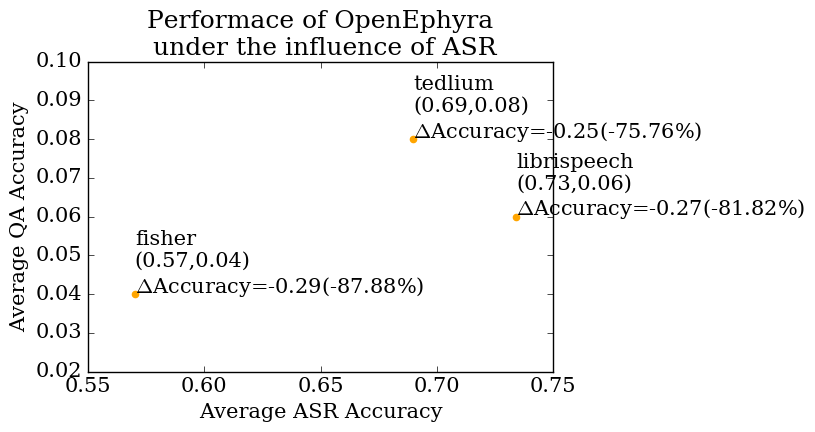

In [24]:
plot_qa_vs_asr(openephyra_stats_list, 'OpenEphyra')

### Observations

1. OpenEphyra is very susceptible to ASR errors
2. There is no correlation between the accuracy of OpenEphyra and that of ASR

### Plot Google QA Performance

avg_asr_error: 0.429871406371 avg_qa_accuracy: 0.22 avg_regular_qa_accuracy 0.91


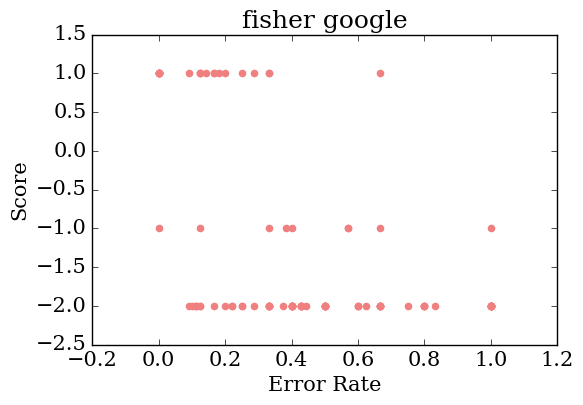

In [25]:
googleqa_stats_list = []
googleqa_stats_list.append(analyze(data, 'fisher', 'google', False))
plot_score_vs_error('lightcoral', **googleqa_stats_list[-1])

avg_asr_error: 0.265864080364 avg_qa_accuracy: 0.4 avg_regular_qa_accuracy 0.91


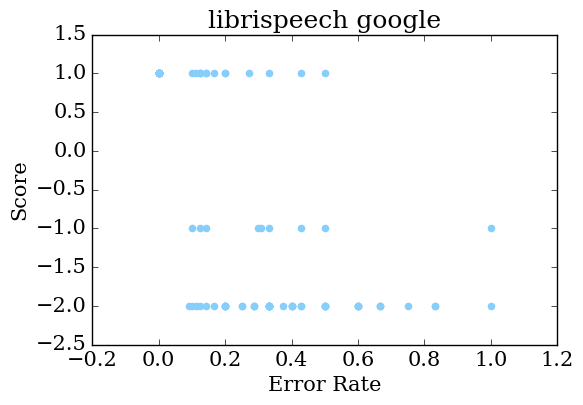

In [26]:
googleqa_stats_list.append(analyze(data, 'librispeech', 'google', False))
plot_score_vs_error('lightskyblue', **googleqa_stats_list[-1])

avg_asr_error: 0.310111083361 avg_qa_accuracy: 0.3 avg_regular_qa_accuracy 0.91


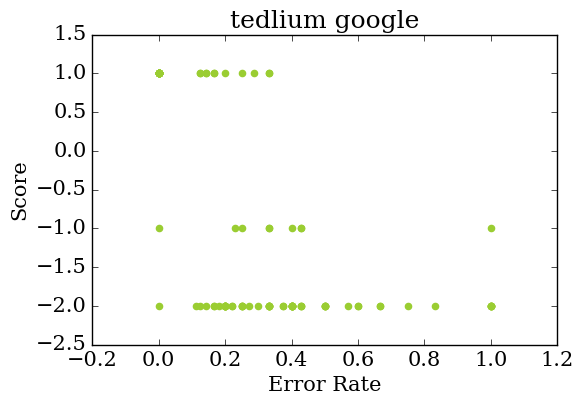

In [27]:
googleqa_stats_list.append(analyze(data, 'tedlium', 'google', False))
plot_score_vs_error('yellowgreen', **googleqa_stats_list[-1])

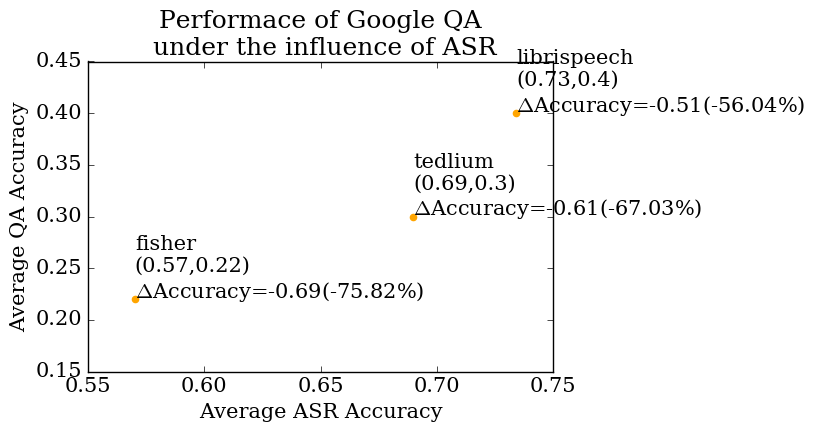

In [28]:
plot_qa_vs_asr(googleqa_stats_list, 'Google QA')

### Observations

1. Google QA is less susceptible to ASR errors than OpenEphyra
2. There is a correlation between the accuracy of Google QA and that of ASR

### Summary

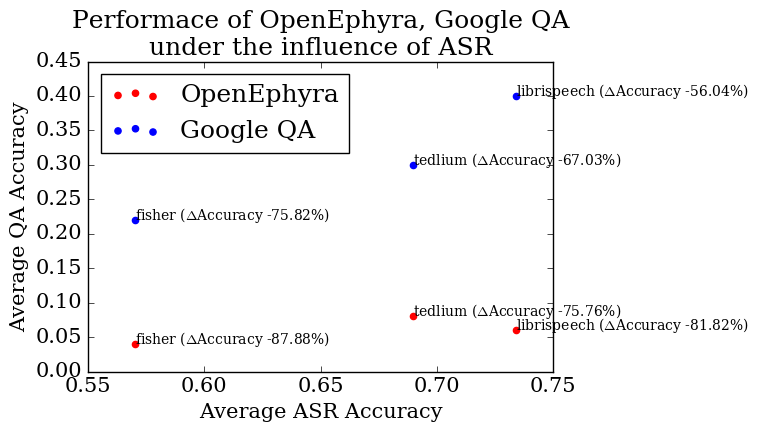

In [29]:
plot_qas_vs_asr([openephyra_stats_list, googleqa_stats_list], \
                ['OpenEphyra', 'Google QA'], ['red', 'blue'])

### Next Steps

1. Constructing pipelines

2. Key: multiple implementations of the same service; could be online, free (IBM, Google, Microsoft)

3. List of services:

    - ASR
    
    - TTS

    - QA

    - Sentimental Analysis

    - Translation

    - Summarization

    - POS and NER

    - OCR

    - Tokenizer (e.g. Stanford CoreNLP)

    - Emotion recognition

    - Speaker Detection
    
4. Conferences: ICML, EMNLP, ACL (Feb.), etc.